绝大多数数据集只需两种方法就可以最好地建模：


• 决策树的集合（即随机森林和梯度提升机），主要用于结构化数据（例如，您可能在大多数公司的数据库表中找到）

• 使用 SGD 学习的多层神经网络（即浅层和/或深度学习），主要用于非结构化数据（如音频、图像和自然语言）

尽管深度学习几乎总是明显优于非结构化数据，但对于多种结构化数据，这两种方法往往会给出非常相似的结果。但是，决策树的系综往往训练得更快，通常更容易解释，不需要特殊的 GPU 硬件进行大规模推理，并且通常需要更少超参数优化。


最重要的是，对于决策树集成来说，解释表格数据模型的关键步骤要容易得多。有一些工具和方法可以回答相关问题，例如：数据集中的哪些列对您的预测最重要？它们与因变量有何关系？它们如何相互作用？哪些特定特征对于某些特定观测最重要？

因此，决策树系综是我们分析新表格数据集的第一种方法。


此准则的例外情况是数据集满足以下条件之一：


• 有一些非常重要的高基数分类变量（“基数”是指表示类别的离散级别的数量，因此高基数分类变量类似于邮政编码，可以具有数千个可能的级别）。

• 有些列包含的数据最好用神经网络来理解，例如纯文本数据。

In [71]:
from fastai.tabular.all import *
from kaggle import api

In [72]:
def file_extract(fname, dest=None):
    "Extract `fname` to `dest` using `tarfile` or `zipfile`."
    if dest is None: dest = Path(fname).parent
    fname = str(fname)
    if fname.endswith('gz'):
        tarfile.open(fname, 'r:gz').extractall(dest)
    elif fname.endswith('zip'):
        zipfile.ZipFile(fname).extractall(dest)
    else:
        raise Exception(f'Unrecognized archive: {fname}')


path = URLs.path('bluebook')
if not path.exists():
    path.mkdir()
    api.competition_download_cli('bluebook-for-bulldozers', path=path)

    file_extract(path / 'bluebook-for-bulldozers.zip')

path.ls()

(#16) [Path('C:/Users/liude/.fastai/archive/bluebook/bluebook-for-bulldozers.zip'),Path('C:/Users/liude/.fastai/archive/bluebook/Data Dictionary.xlsx'),Path('C:/Users/liude/.fastai/archive/bluebook/Machine_Appendix.csv'),Path('C:/Users/liude/.fastai/archive/bluebook/median_benchmark.csv'),Path('C:/Users/liude/.fastai/archive/bluebook/random_forest_benchmark_test.csv'),Path('C:/Users/liude/.fastai/archive/bluebook/Test.csv'),Path('C:/Users/liude/.fastai/archive/bluebook/to.pkl'),Path('C:/Users/liude/.fastai/archive/bluebook/Train.7z'),Path('C:/Users/liude/.fastai/archive/bluebook/Train.zip'),Path('C:/Users/liude/.fastai/archive/bluebook/TrainAndValid.7z')...]

In [73]:
df = pd.read_csv(path / 'TrainAndValid.csv', low_memory=False)
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [74]:
# 先把这种处理掉
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [75]:
# 具有自然的顺序
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'
df['ProductSize'] = df['ProductSize'].astype('category')

In [76]:
# df['ProductSize'].cat.set_categories(sizes, ordered=True,inplace=True)
df['ProductSize'].cat.set_categories(sizes, ordered=True)

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In [77]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

In [78]:
df = add_datepart(df, 'saledate')

C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\fastai\tabular\core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


In [79]:
df_test = pd.read_csv(path / 'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\fastai\tabular\core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


In [80]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [81]:
# 处理字符串和缺失值
procs = [Categorify, FillMissing]

In [82]:
cond = (df.saleYear < 2011) | (df.saleMonth < 10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx), list(valid_idx))

In [83]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\fastai\tabular\core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [84]:
len(to.train), len(to.valid)

(404710, 7988)

In [93]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [94]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,963,298,43,0,0,0,59,1,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2006,11,46,16,3,320,1,1,1,1,1,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,1745,529,57,98,0,4,62,33,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2004,3,13,26,4,86,1,1,1,1,1,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,336,111,0,0,0,0,39,32,3,3,0,6,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,2004,2,9,26,3,57,1,1,1,1,1,1,1.077754e+09,1,1


In [87]:
to.classes['ProductSize']

['#na#', 'Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small']

In [88]:
save_pickle(path / 'to.pkl', to)

to = load_pickle(path / 'to.pkl')

In [96]:
# 创建决策树。
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

(404710, 66)

In [109]:
from sklearn.tree import DecisionTreeRegressor

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs.values, y.values)

DecisionTreeRegressor(max_leaf_nodes=4)

In [110]:
from utils import draw_tree
from IPython.display import display
import os

graph = draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)
graph.render('image', view=True)

'image.pdf'

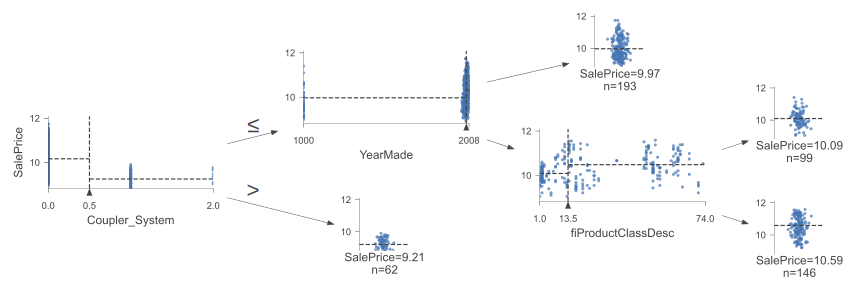

In [113]:
import dtreeviz

samp_idx = np.random.permutation(len(y))[:500]
viz_model = dtreeviz.model(m,
                           X_train=xs.iloc[samp_idx],
                           y_train=y.iloc[samp_idx],
                           feature_names=xs.columns,
                           target_name=dep_var)

viz_model.view(scale=1.6, label_fontsize=10,
               orientation='LR')

In [114]:
xs.loc[xs['YearMade'] < 1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade'] < 1900, 'YearMade'] = 1950

C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


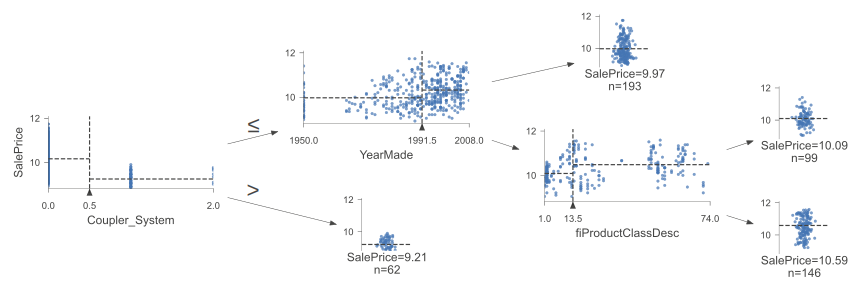

In [115]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)
viz_model = dtreeviz.model(m,
                           X_train=xs.iloc[samp_idx],
                           y_train=y.iloc[samp_idx],
                           feature_names=xs.columns,
                           target_name=dep_var)

viz_model.view(scale=1.6, label_fontsize=10,
               orientation='LR')

In [119]:
m = DecisionTreeRegressor()
m.fit(xs, y)

DecisionTreeRegressor()

In [120]:
def r_mse(pred, y): return round(math.sqrt(((pred - y) ** 2).mean()), 6)


def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)


m_rmse(m, xs, y)

0.0

In [121]:
m_rmse(m, valid_xs, valid_y)

0.32992

In [122]:
m.get_n_leaves(), len(xs)

(324338, 404710)

In [123]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.243051, 0.309338)

In [124]:
m.get_n_leaves()

12432

In [134]:
from sklearn.ensemble import RandomForestRegressor


# 随机森林
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)


m = rf(xs, y);

In [135]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171492, 0.232572)

In [136]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor w

In [137]:
r_mse(preds.mean(0), valid_y)

0.232572

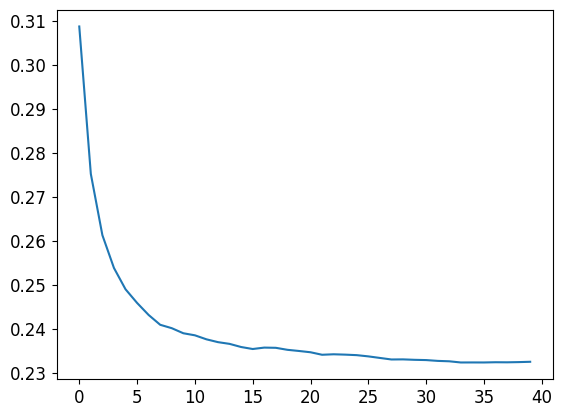

In [138]:
plt.plot([r_mse(preds[:i + 1].mean(0), valid_y) for i in range(40)])

In [41]:
r_mse(m.oob_prediction_, y)

0.211579

In [139]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
preds.shape

C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor w

(40, 7988)

In [140]:
preds_std = preds.std(0)
preds_std[:5]

array([0.29187204, 0.1502204 , 0.11937626, 0.23883272, 0.14189596])

In [142]:
def rf_feat_importance(m, df):
    return pd.DataFrame({
        'cols': df.columns,
        'imp': m.feature_importances_
    }).sort_values('imp', ascending=False)


fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.175860
30,Coupler_System,0.104885
6,ProductSize,0.102241
7,fiProductClassDesc,0.087818
31,Grouser_Tracks,0.069402
54,ModelID,0.058630
65,saleElapsed,0.050384
3,fiSecondaryDesc,0.039963
32,Hydraulics_Flow,0.037596
1,fiModelDesc,0.032901


In [ ]:
fi = rf_feat_importance(m, df)
fi.head(10)

<Axes: ylabel='cols'>

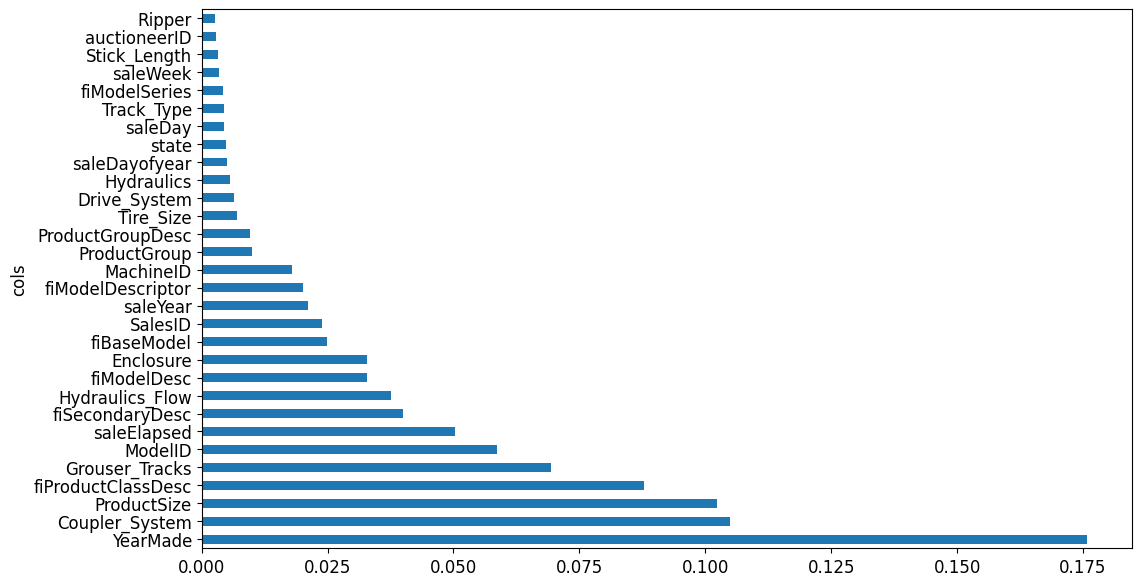

In [146]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False)


plot_fi(fi[:30])

In [149]:
# 删掉那些用处不大的特征
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

21

In [150]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m = rf(xs_imp, y)

In [151]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181447, 0.230897)

In [152]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

<Axes: ylabel='cols'>

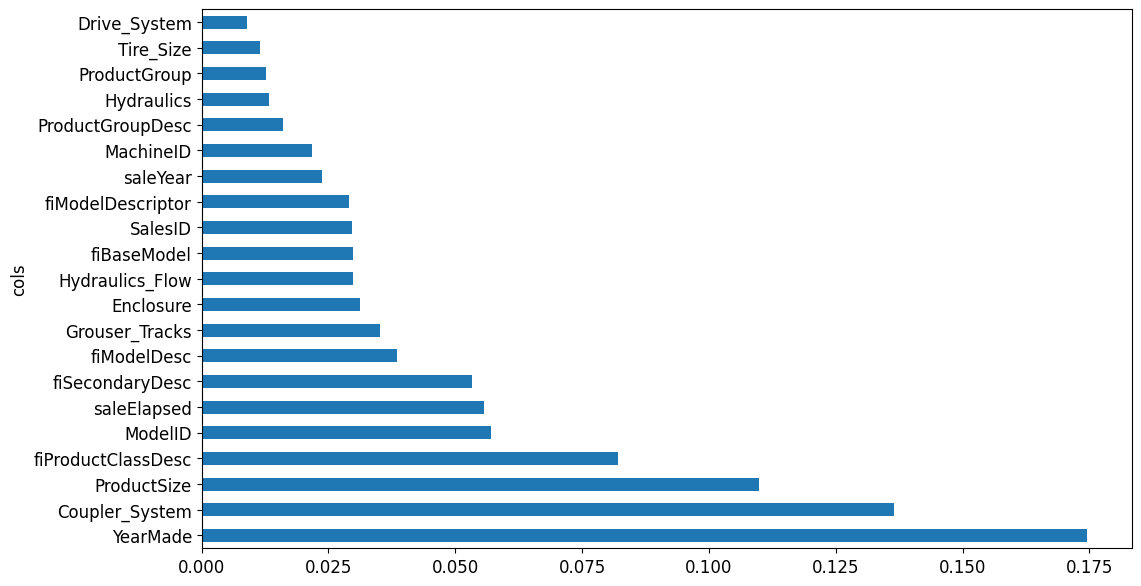

In [153]:
plot_fi(rf_feat_importance(m, xs_imp))

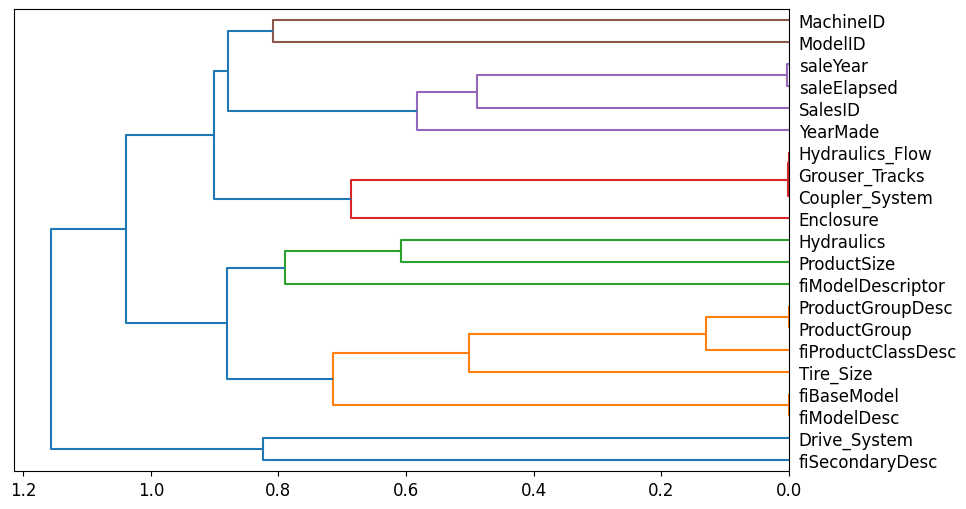

In [155]:
from learning_fastai.utils import cluster_columns

cluster_columns(xs_imp)

In [156]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
                              max_samples=50000, max_features=0.5, oob_score=True)
    m.fit(df, y)
    return m.oob_score_


get_oob(xs_imp)

0.8758977861844527

In [157]:
{
    c: get_oob(xs_imp.drop(c, axis=1)) for c in (
        'saleYear', 'saleElapsed', 'ProductGroupDesc', 'ProductGroup',
        'fiModelDesc', 'fiBaseModel',
        'Hydraulics_Flow', 'Grouser_Tracks', 'Coupler_System'
    )
}

{'saleYear': 0.8748697755418141,
 'saleElapsed': 0.8711257226964253,
 'ProductGroupDesc': 0.8765659700096718,
 'ProductGroup': 0.8763538360829697,
 'fiModelDesc': 0.8745327947822839,
 'fiBaseModel': 0.8750115274911177,
 'Hydraulics_Flow': 0.8768665065079649,
 'Grouser_Tracks': 0.8767817450254254,
 'Coupler_System': 0.8766996664234554}

In [158]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8729554203515707

In [160]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

save_pickle(path / 'xs_final.pkl', xs_final)
save_pickle(path / 'valid_xs_final.pkl', valid_xs_final)

In [162]:
xs_final = load_pickle(path / 'xs_final.pkl')
valid_xs_final = load_pickle(path / 'valid_xs_final.pkl')

In [163]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183797, 0.233013)

([<matplotlib.axis.YTick at 0x1fc986cdc90>,
 [Text(0, 0, '#na#'),
  Text(0, 1, 'Compact'),
  Text(0, 2, 'Large'),
  Text(0, 3, 'Large / Medium'),
  Text(0, 4, 'Medium'),
  Text(0, 5, 'Mini'),
  Text(0, 6, 'Small')])

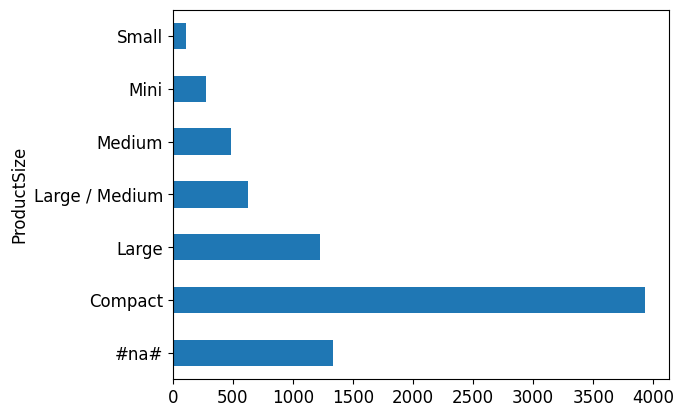

In [164]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c)

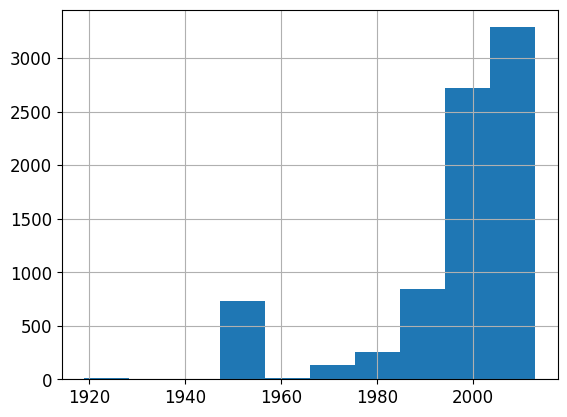

In [165]:
ax = valid_xs_final['YearMade'].hist()

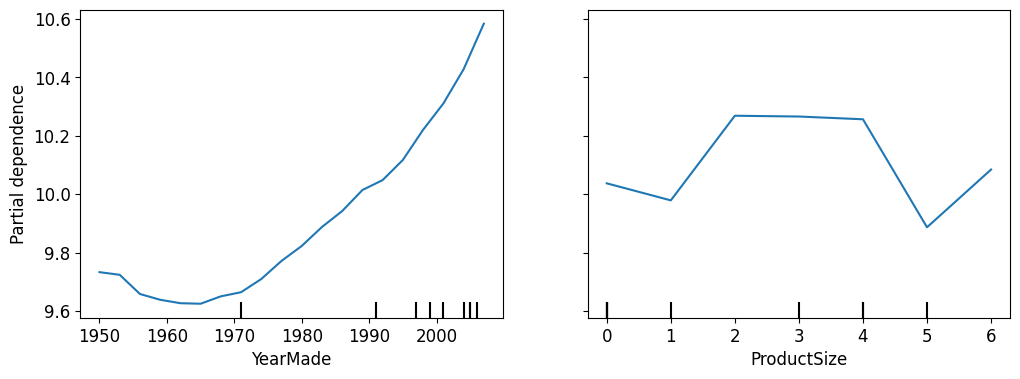

In [167]:
# Partial Dependence
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(m, valid_xs_final, ['YearMade', 'ProductSize'], grid_resolution=20, ax=ax)


In [168]:
!pip install treeinterpreter
!pip install waterfallcharts

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3396 sha256=2adcf6c34c10030eb5dcb1d1493c1bfbb41fea0cb62b72e59d9a9b7c673a6ee5
  Stored in directory: c:\users\liude\appdata\local\pip\cache\wheels\ae\63\04\33cea685117d88e3cb159d14ae54d51c6aead156b8b08ad53e
Successfully built waterfallcharts


In [170]:
# 对于特定行数据的预测，最重要的因素是什么，它们如何影响该预测？
row = valid_xs_final.iloc[:5]

In [172]:
from treeinterpreter import treeinterpreter as ti

prediction, bias, contributions = ti.predict(m, row.values)

In [173]:
prediction[0], bias[0], contributions[0].sum()

(array([10.11713783]), 10.104188292000174, 0.012949533045390857)

C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\waterfall_chart.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\waterfall_chart.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


<module 'matplotlib.pyplot' from 'C:\\Users\\liude\\.conda\\envs\\torch22cu121\\Lib\\site-packages\\matplotlib\\pyplot.py'>

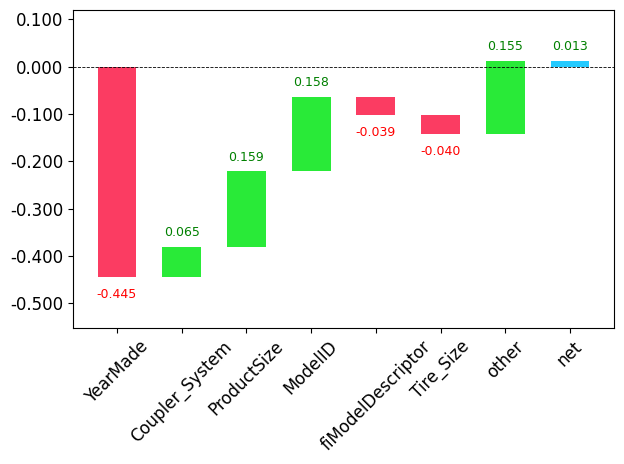

In [181]:
from waterfall_chart import plot as waterfall

waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, rotation_value=45, formatting='{:.3f}')

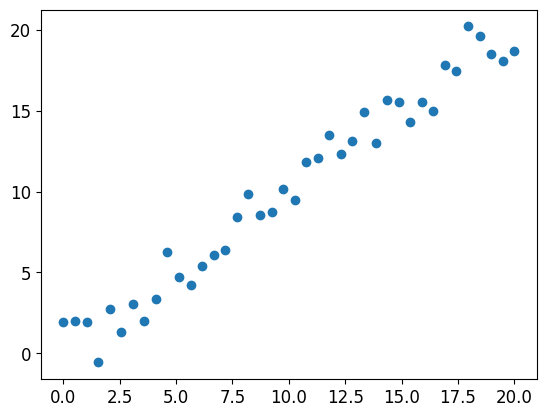

In [182]:
# 深度学习可以利用好扩展数据
x_lin = torch.linspace(0, 20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)

plt.scatter(x_lin, y_lin)

In [184]:
# sklearn期待矩阵
xs_lin = x_lin.unsqueeze(1)
x_lin.shape, xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [185]:
x_lin[:, None].shape

torch.Size([40, 1])

In [186]:
m_lin = RandomForestRegressor().fit(xs_lin[:30], y_lin[:30])

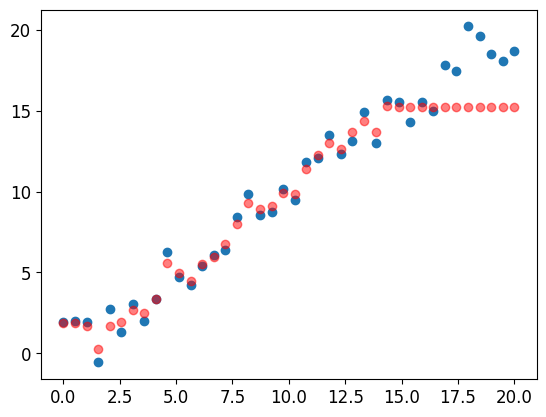

In [187]:
# 树和随机森林永远无法预测训练数据范围之外的值。
plt.scatter(x_lin, y_lin)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5)

In [188]:
# 用随机森林predict whether a row is in the validation set or the training set.
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0] * len(xs_final) + [1] * len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.878454
10,SalesID,0.101076
12,MachineID,0.014879
0,YearMade,0.001742
9,Enclosure,0.000765
8,fiModelDesc,0.000610


In [189]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID', 'saleElapsed', 'MachineID'):
    m = rf(xs_final.drop(c, axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c, axis=1), valid_y))


orig 0.232694
SalesID 0.230961
saleElapsed 0.236049
MachineID 0.231315


In [204]:
time_vars = ['SalesID', 'MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.229546

In [192]:
# 这很好，建议以后都这样干，来个is_valid。

<Axes: >

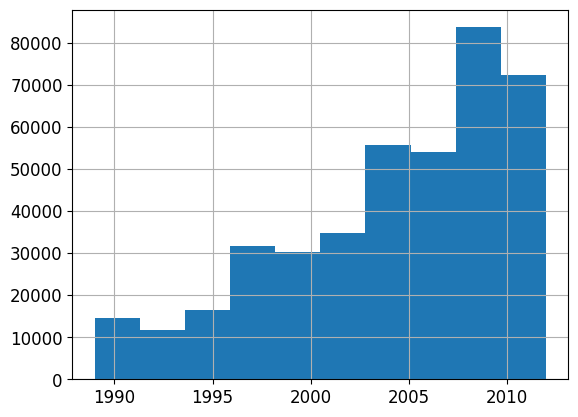

In [193]:
xs['saleYear'].hist()

In [194]:
filt = xs['saleYear'] > 2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.178012, 0.229662)

In [218]:
df_nn = pd.read_csv(path / 'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

C:\Users\liude\.conda\envs\torch22cu121\Lib\site-packages\fastai\tabular\core.py:25: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [219]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [220]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [221]:
cont_nn

['saleElapsed']

In [209]:
cont_nn.append('saleElapsed')
cat_nn.append('saleElapsed')

In [222]:
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Hydraulics_Flow          3
fiModelDesc           5059
Enclosure                6
fiModelDescriptor      140
ProductGroup             6
Tire_Size               17
Drive_System             4
Hydraulics              12
dtype: int64

In [223]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.177103, 0.229336)

In [224]:
cat_nn.remove('fiModelDescriptor')

In [225]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [226]:
dls = to_nn.dataloaders(1024)


In [228]:
y = to_nn.train.y
y.min(), y.max()

(8.465899, 11.863583)

SuggestedLRs(valley=0.0002754228771664202)

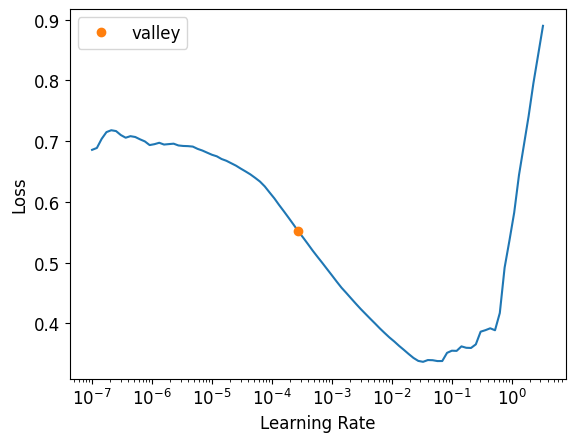

In [229]:
from fastai.tabular.all import *

learn = tabular_learner(dls, y_range=(8,12), layers=[500,250], n_out=1, loss_func=F.mse_loss)
learn.lr_find()

In [230]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.062772,0.066899,00:03
1,0.051935,0.057227,00:03
2,0.046821,0.055728,00:03
3,0.042037,0.054364,00:03
4,0.040221,0.052221,00:03


In [232]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

0.228519

In [233]:
learn.save('nn')

Path('models/nn.pth')

In [234]:
# 不同模型的ensemble
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) / 2

In [235]:
r_mse(ens_preds, valid_y)

0.223204

In [ ]:
# boosting



我们建议从随机森林开始分析。这将为您提供一个强大的基线，您可以确信这是一个合理的起点。然后，您可以使用该模型进行特征选择和部分依赖性分析，以更好地了解您的数据。
在此基础上，您可以尝试神经网络和 GBM，如果它们在合理的时间内为您的验证集提供了明显更好的结果，则可以使用它们。如果决策树集成对您来说效果很好，请尝试将分类变量的嵌入点添加到数据中，看看这是否有助于您的决策树更好地学习。